In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sspspace

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Random Encoding

In __init__ with class <class 'sspspace.ssp.SSP'>
In __init__ with class <class 'sspspace.ssp.SSP'>


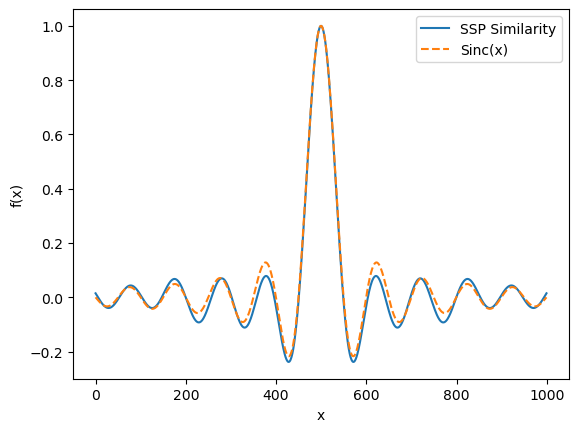

In [14]:
xs = np.linspace(-10,10,1000).reshape((-1,1))
rand_encoder = sspspace.RandomSSPSpace(domain_dim=1,ssp_dim=1024*2)

query_xs_ssp = rand_encoder.encode(xs)
origin_ssp = rand_encoder.encode([[0]])

sims = query_xs_ssp | origin_ssp
true_sims = np.sinc(xs)
    
error = np.mean(np.power(sims-true_sims, 2))

assert error < 0.01, f'Expected error of 0.01, got {error}'
plt.plot(sims, label='SSP Similarity')
plt.plot(true_sims, ls='--', label='Sinc(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

In __init__ with class <class 'sspspace.ssp.SSP'>


([], [])

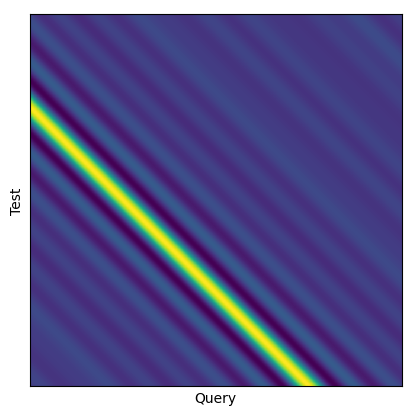

In [13]:
test_xs_ssp = rand_encoder.encode(np.linspace(-5,15,1000).reshape((-1,1)))
sims_2d = query_xs_ssp | test_xs_ssp
plt.matshow(sims_2d)
plt.xlabel('Query')
plt.ylabel('Test')
plt.xticks([])
plt.yticks([])

# Hexagonal SSPs

In __init__ with class <class 'sspspace.ssp.SSP'>
In __init__ with class <class 'sspspace.ssp.SSP'>


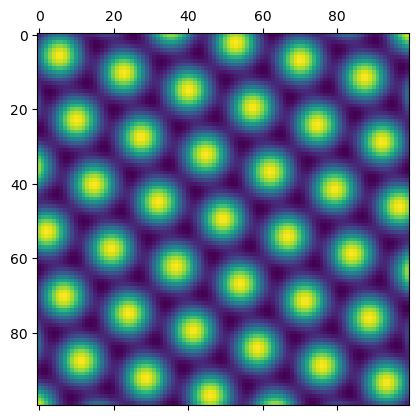

In [16]:
xs = np.linspace(-2,2,100).reshape((-1,1))
ys = np.linspace(-2,2,100).reshape((-1,1))

X, Y = np.meshgrid(xs, ys)
xys = np.vstack((X.flatten(), Y.flatten())).T

hex_encoder = sspspace.HexagonalSSPSpace(domain_dim=2, n_rotates=1, n_scales=1)
hex_encoder.update_lengthscale(0.01)

query_xys_ssp = hex_encoder.encode(xys)
origin_ssp = hex_encoder.encode([[0,0]])

sims = query_xys_ssp | origin_ssp
square_sims = sims.reshape((ys.shape[0], xs.shape[0]))

plt.matshow(square_sims)

# Bundling

In __init__ with class <class 'sspspace.ssp.SSP'>
In __init__ with class <class 'sspspace.ssp.SSP'>
In __init__ with class <class 'sspspace.ssp.SSP'>


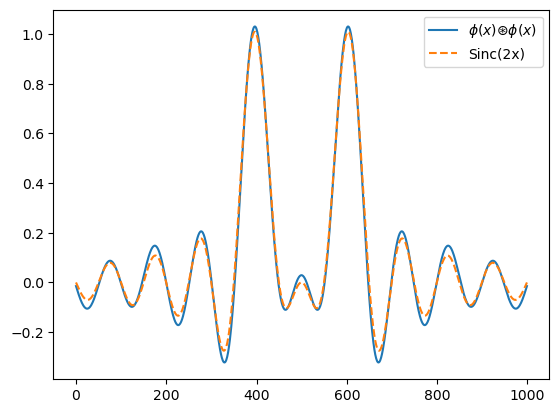

In [30]:
xs = np.linspace(-10,10,1000).reshape((-1,1))
rand_encoder = sspspace.RandomSSPSpace(domain_dim=1,ssp_dim=1024*2)
 
query_xs_ssp = rand_encoder.encode(xs)
origin_ssp = rand_encoder.encode([[-2]]) + rand_encoder.encode([[2]])
 
sims = query_xs_ssp | origin_ssp
true_sims = np.sinc(xs-2) + np.sinc(xs+2)
error = np.mean(np.power(sims-true_sims, 2))

plt.plot(sims, label=r'$\phi(x)\circledast\phi(x)$')
plt.plot(true_sims, ls='--', label='Sinc(2x)')
plt.legend()

# Binding

Assumes we are binding the same number of vectors together, pairwise.

In __init__ with class <class 'sspspace.ssp.SSP'>
In __init__ with class <class 'sspspace.ssp.SSP'>


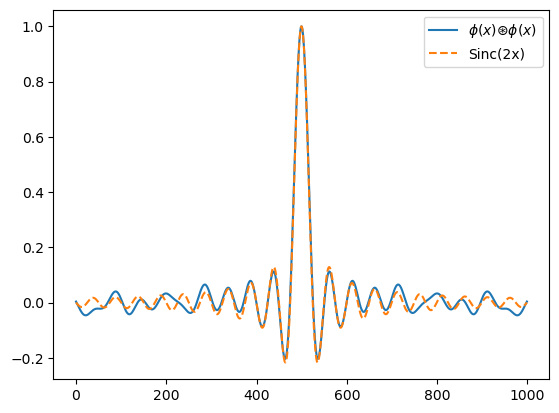

In [29]:
xs = np.linspace(-10,10,1000).reshape((-1,1))
rand_encoder = sspspace.RandomSSPSpace(domain_dim=1,ssp_dim=1024*2)
 
query_xs_ssp = rand_encoder.encode(xs)
origin_ssp = rand_encoder.encode([[0]])
 
bound_self = query_xs_ssp * query_xs_ssp
sims = bound_self | origin_ssp
true_sims = np.sinc(2 * xs)
error = np.mean(np.power(sims-true_sims, 2))

plt.plot(sims, label=r'$\phi(x)\circledast\phi(x)$')
plt.plot(true_sims, ls='--', label='Sinc(2x)')
plt.legend()

# Invert

In __init__ with class <class 'sspspace.ssp.SSP'>


<StemContainer object of 3 artists>

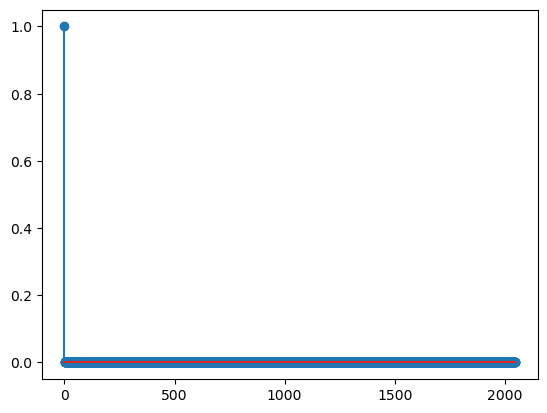

In [25]:
rand_encoder = sspspace.RandomSSPSpace(domain_dim=1,ssp_dim=1024*2)
 
origin_ssp = rand_encoder.encode([[0]])
origin_inv_ssp = ~origin_ssp
 
bound_vec = origin_inv_ssp * origin_ssp

plt.stem(np.arange(bound_vec.shape[1]), bound_vec.T)

# Decode SSPs

In [6]:
bounds = np.array([[-10,10]])
ssp_encoder = sspspace.RandomSSPSpace(domain_dim=1,ssp_dim=128)
ssp_decoder, training_history = sspspace.train_decoder_net(ssp_encoder, bounds, 
                                    n_training_pts=200000, # number of points sample from domain
                                    hidden_units=[8], # list of neurons in dense hidden layers
                                    learning_rate=1e-3, # learning rate for Adam
                                    n_epochs=100, # Max epochs
                                    patience=3, # patience for early stopping
                                    verbose=True # print tensorflow training nonsense.
                                )




In __init__ with class <class 'sspspace.ssp.SSP'>


In [35]:
xs = np.random.uniform(low=bounds[0,0],high=bounds[0,1], size=(100,1))
enc_ssps = ssp_encoder.encode(xs)

Text(0.5, 0, 'Epoch number')

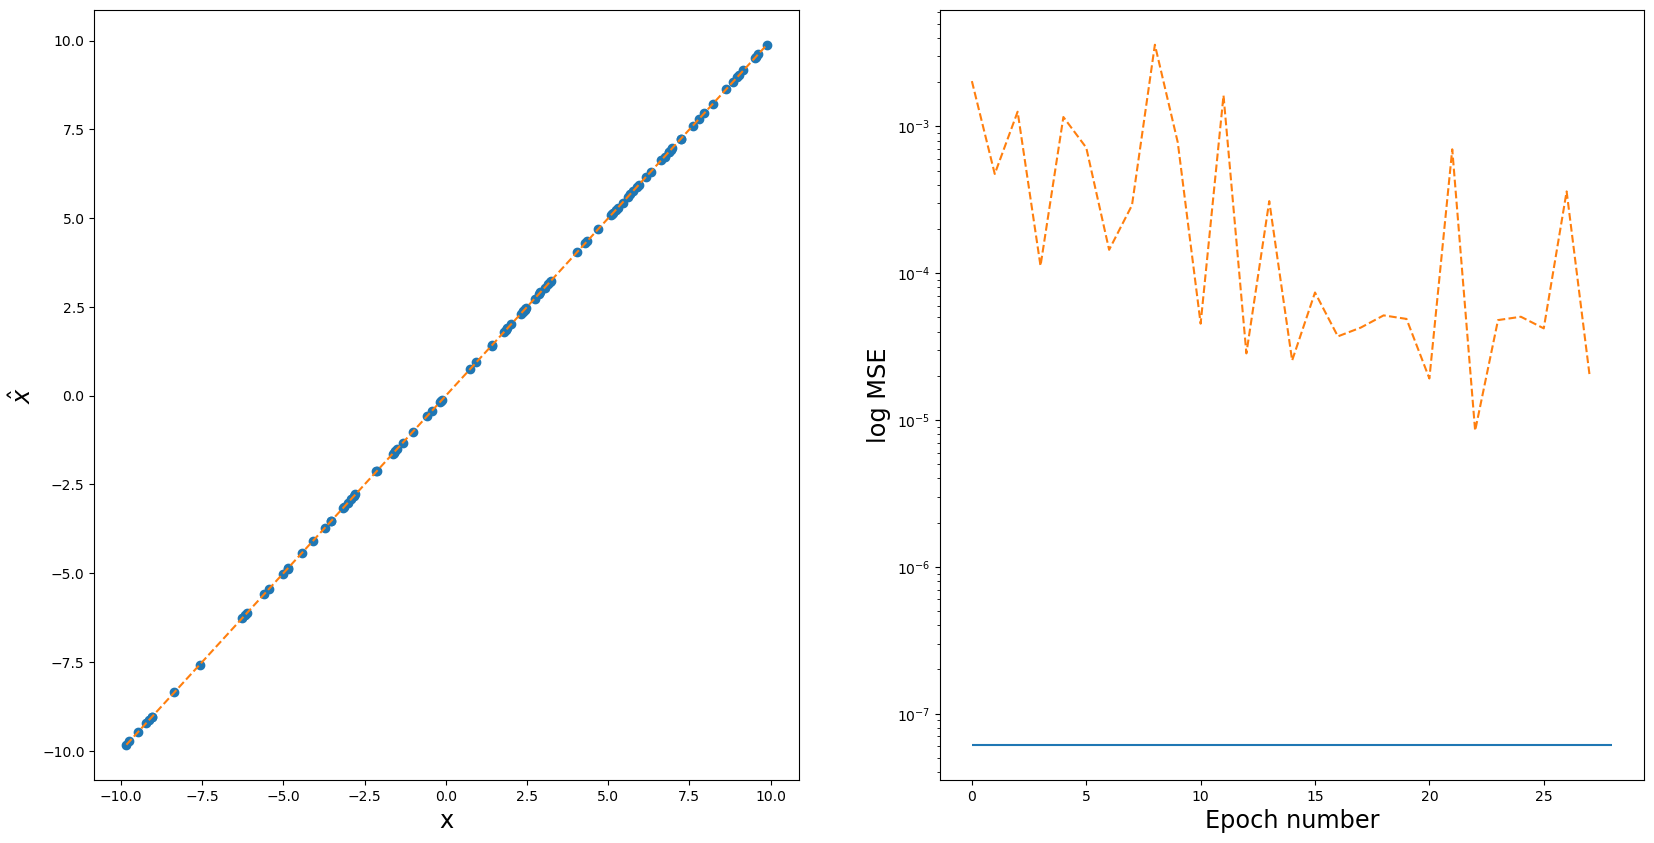

In [37]:
dec_xs = ssp_decoder.decode(enc_ssps)

errors = dec_xs - xs
mu_err = np.mean(errors)
ste_err = np.std(errors) / np.sqrt(xs.shape[0])

max_epochs = len(training_history.history['val_loss'])

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(xs, dec_xs)
plt.plot([xs.min(), xs.max()],[xs.min(), xs.max()], ls='--', c='tab:orange')
plt.xlabel('x', fontsize='xx-large')
plt.ylabel(r'$\hat{x}$', fontsize='xx-large')

plt.subplot(1,2,2)
plt.plot(training_history.history['val_loss'], label='Validation loss', ls='--', c='tab:orange')
plt.hlines(y=[mu_err - 1.96 * ste_err, mu_err + 1.96 * ste_err], xmin=0, xmax=max_epochs, label='')
plt.yscale('log')
plt.ylabel('log MSE', fontsize='xx-large')
plt.xlabel('Epoch number', fontsize='xx-large')